<font size="6"><center>**Compute Targets**</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, accuracy_score

In [4]:
from src.data_api import sources
from src import utils, tags

from src import data_preparation as dataprep 

In [59]:
conf = utils.get_conf()

In [60]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_qthres = float(fparams['avol_qtheshold'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

In [30]:
ticker = 'AMZN'

# Load Data

In [7]:
wiki_prices = sources.read_wiki_prices()

In [8]:
pd.concat([wiki_prices.head(2), wiki_prices.tail(2)], axis=0)

open    high     low   close          volume  \
ticker date                                                         
A      1999-11-18 45.5000 50.0000 40.0000 44.0000 44,739,900.0000   
       1999-11-19 42.9400 43.0000 39.8100 40.3800 10,897,100.0000   
ZUMZ   2018-03-26 23.7500 24.8000 23.7000 24.6500    375,320.0000   
       2018-03-27 24.6500 24.6500 23.3500 23.6000    403,884.0000   

                   ex-dividend  split_ratio  adj_open  adj_high  adj_low  \
ticker date                                                                
A      1999-11-18       0.0000       1.0000   31.0420   34.1120  27.2896   
       1999-11-19       0.0000       1.0000   29.2954   29.3363  27.1600   
ZUMZ   2018-03-26       0.0000       1.0000   23.7500   24.8000  23.7000   
       2018-03-27       0.0000       1.0000   24.6500   24.6500  23.3500   

                   adj_close      adj_volume  
ticker date                                   
A      1999-11-18    30.0186 44,739,900.0000  
       1999-11-19    27.5489 10,897,100.0000  
ZUMZ   2018-03-26    24.6500    375,320.0000  
       2018-03-27    23.6000    403,884.0000

In [9]:
wiki_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Columns: 12 entries, open to adj_volume
dtypes: float64(12)
memory usage: 1.4+ GB


# Data Preparation

In [47]:
avol = wiki_prices.groupby(tags.TICKER)[tags.VOLUME].transform(lambda grp: grp.rolling(30).mean())

In [21]:
n_tickers = wiki_prices.reset_index(tags.TICKER).groupby(tags.DATE).size()

## Pipeline

```python
def log_returns(prices: pd.Series, tau: int) -> pd.Series:
    """
    Compute log returns on time series data
    log(p2/p1) = log(p2) - log(p1)
    @param prices: time series data
    @param tau: differencing period
    @return: returns
    """


def pl_targets(data: pd.DataFrame, tau_fwd: int) -> pd.DataFrame:
    """
    Target computation on close price
    @param data: input
    @param tau_fwd: target time horizon (forward)
    @return: output
    """
    
def pl_min_avol_filter(data: pd.DataFrame, window: int, min_adv: int) -> pd.DataFrame:
    """
    Compute rolling Average Volume by ticker and filter top quantile
    @param data: input
    @param window: number o periods to compute rolling mean
    @param qthreshold: filter threshold (top quantile)
    @return: output
    """
    
def pl_date_filter(data: pd.DataFrame, start_dt: str, end_dt: str) -> pd.DataFrame:
    """
    Apply a filter to index level `date`
    @param data: input
    @param start_dt: Filter start
    @param end_dt: Filter end
    @return: output
    """


def pl_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute feautures:
        x_returns_5d: 5 days momentum indicator, log_returns(p[t-5], p[t])
        x_returns_1d: 1 day momentum indicator, log_returns(p[t-1], p[t])
    :param data: input
    :return:  output
    """

   


In [63]:
feats_and_targets = (wiki_prices
                     .pipe(dataprep.pl_targets, tau_fwd=tau)
                     .pipe(dataprep.pl_features)
                     .pipe(dataprep.pl_min_avol_filter, window=avol_window, qthreshold=avol_qthres)
                     .pipe(dataprep.pl_date_filter, start_dt=start_dt, end_dt=end_dt)
                    )

In [68]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

open    high     low   close         volume  ex-dividend  \
ticker date                                                                     
A      2015-01-02 41.1800 41.3100 40.3700 40.5600 1,530,798.0000       0.1000   
       2015-01-05 40.3200 40.4600 39.7000 39.8000 2,042,240.0000       0.0000   
ZUMZ   2017-10-17 17.0000 17.3500 16.8000 17.0000   264,501.0000       0.0000   
       2017-10-18 17.1500 17.4500 16.9500 17.4000   232,349.0000       0.0000   

                   split_ratio  adj_open  adj_high  adj_low  adj_close  \
ticker date                                                              
A      2015-01-02       1.0000   40.0388   40.1652  39.2512    39.4360   
       2015-01-05       1.0000   39.2026   39.3387  38.5998    38.6970   
ZUMZ   2017-10-17       1.0000   17.0000   17.3500  16.8000    17.0000   
       2017-10-18       1.0000   17.1500   17.4500  16.9500    17.4000   

                      adj_volume   dollar_volume  target  x_returns_5d  \
ticker date                                                              
A      2015-01-02 1,530,798.0000 60,368,486.5103 -0.0007       -0.0115   
       2015-01-05 2,042,240.0000 79,028,603.1304 -0.0078       -0.0365   
ZUMZ   2017-10-17   264,501.0000  4,496,517.0000 -0.0516       -0.0980   
       2017-10-18   232,349.0000  4,042,872.6000 -0.0367       -0.0477   

                   x_returns_1y  
ticker date                      
A      2015-01-02        0.0002  
       2015-01-05       -0.0329  
ZUMZ   2017-10-17       -0.2781  
       2017-10-18       -0.2481

In [69]:
singl_stock = feats_and_targets.loc[ticker]

In [70]:
feats_and_targets[['x_returns_5d', tags.TARGET ]].isna().sum(axis=0)

x_returns_5d    0
target          0
dtype: int64

In [71]:
feats_and_targets['x_returns_5d'] = feats_and_targets['x_returns_5d'].fillna(0)

# Visualization

## Trading Population (Universe)

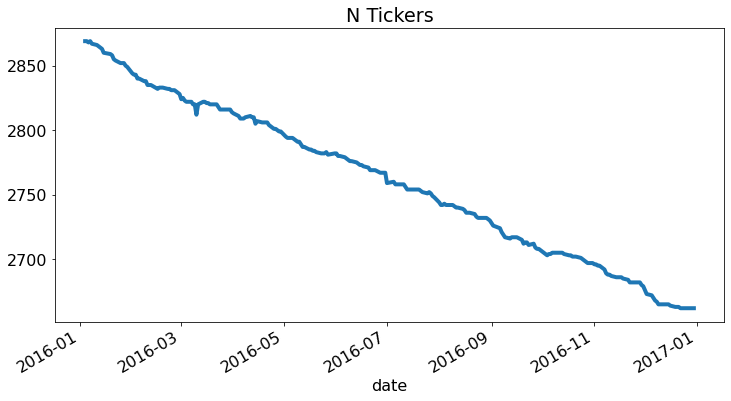

In [72]:
n_tickers['2016'].plot()
plt.title('N Tickers')
plt.show()

In [73]:
wiki_prices[tags.VOLUME].describe()

count      15,389,314.0000
mean        1,412,932.3279
std         6,535,417.7660
min                 0.0000
25%            46,800.0000
50%           232,100.0000
75%           907,200.0000
max     2,304,018,600.0000
Name: adj_volume, dtype: float64

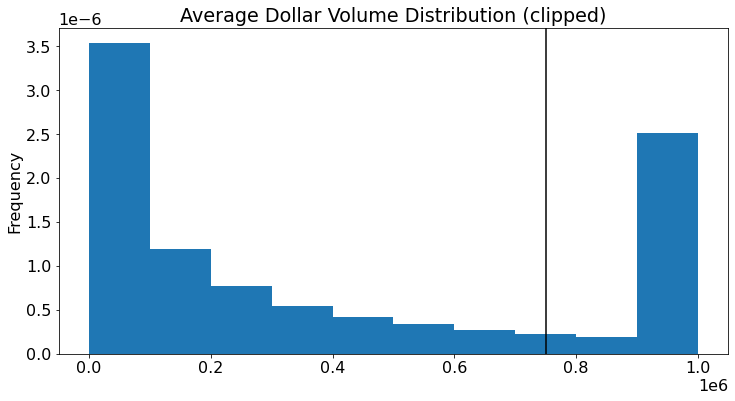

In [74]:
wiki_prices[tags.VOLUME].clip(upper=1e6).plot.hist(density=True)
plt.axvline(x=7.5e5, color='black', linewidth=1.5)
plt.title("Average Dollar Volume Distribution (clipped)")
plt.show()

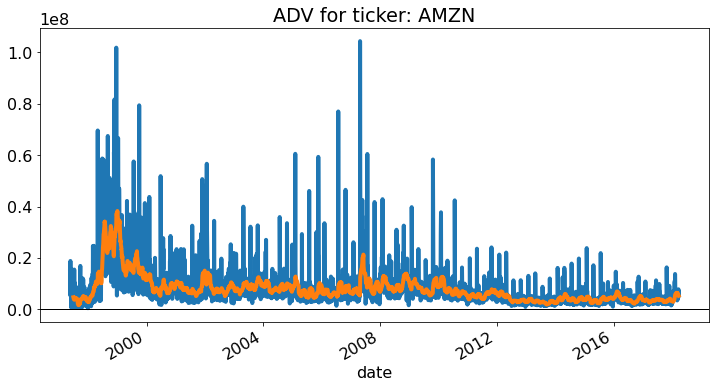

In [75]:
ax = wiki_prices.loc[ticker, tags.VOLUME].plot()
avol[ticker].plot(ax=ax)
plt.axhline(y=1e4, color='black', linewidth=1)
plt.title(f'ADV for ticker: {ticker}')

plt.show()

## Single stock Visulalizations

In [76]:
#feats_and_targets.index.get_level_values('ticker').unique().tolist()

<AxesSubplot:xlabel='date'>

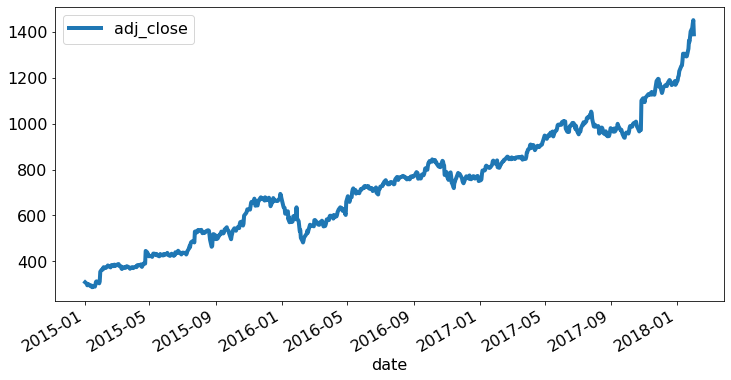

In [77]:
singl_stock.plot(y=tags.CLOSE)

In [78]:
singl_stock.plot(y='x_returns_1d')

KeyError: 'x_returns_1d'

## Stationarity

In [ ]:
adfuller(singl_stock[tags.CLOSE])

In [ ]:
adfuller(singl_stock['x_returns_1d'])

## Descriptive Statistics

In [ ]:
singl_stock['x_returns_1d'].describe()

In [ ]:
singl_stock_roll20 = singl_stock.rolling(20)

singl_stock = singl_stock.assign(
    returns_1d_mave20=singl_stock_roll20['x_returns_1d'].std(),
    returns_1d_mstd20=singl_stock_roll20['x_returns_1d'].mean())

In [ ]:
singl_stock.plot(y=['returns_1d_mave20', 'returns_1d_mstd20'])
plt.axhline(y=0, linewidth=1, color='grey')

## ACF and PACF

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(16,10), sharex=True)

ax = axs[0]
plot_acf(singl_stock['x_returns_1d'], ax=ax)

ax = axs[1]
plot_pacf(singl_stock['x_returns_1d'], ax=ax)

plt.show()

# Benchmark model

In [79]:
feats_and_targets[['x_returns_5d', tags.TARGET]].corr(method='spearman')

,x_returns_5d,target
x_returns_5d,1.0000,0.0155
target,0.0155,1.0000


In [80]:
mean_squared_error(y_true=feats_and_targets['x_returns_5d'], y_pred=feats_and_targets[tags.TARGET])

0.009233089677703516

In [81]:
accuracy_score(y_true=np.sign(feats_and_targets['x_returns_5d']), y_pred=np.sign(feats_and_targets[tags.TARGET]))

0.49831213189642737